# Import packages & functions

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

import ddp_config
distributed,local_rank = ddp_config.ddp_test()
if device=='cuda': torch.cuda.set_device(local_rank)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

seed=42
utils.seed_everything(seed=seed)

device: cuda
NOT using distributed parallel processing!


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


## Load CLIP extractor

In [2]:
clip_extractor = Clipper("ViT-L/14", 
                         clamp_embs=False, 
                         norm_embs=False, 
                         device=device)

ViT-L/14 cuda


# CLIP retrieval evaluation

### Load model checkpoint

In [ ]:
model_name = "voxel2clip"

outdir = f'../train_logs/models/{model_name}/test'

ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)

utils.plot_brainnet_ckpt(ckpt_path)

### Load pretrained weights onto model

In [ ]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
diffusion_prior = BrainDiffusionPrior.from_pretrained(
    dict(),
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
)

diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
diffusion_prior.eval().to(device)
print("loaded")

### Prep data loader

In [9]:
batch_size = 300 # same as used in mind_reader

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_samples=None,
        seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        num_samples=None,
        seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
train_url /scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar
val_url /scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 90
num_train 27150
num_val 300
cache_dir None
validation: num_worker_batches 1
idx 0
voxel.shape torch.Size([300, 15724])
img_input.shape torch.Size([300, 3, 256, 256])
key[:2] ['sample09960', 'sample01071']


## Forward / Backward quantification

In [38]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            
            emb = clip_extractor.embed_image(img) # CLIP-Image
            
            #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text
            
            # l2norm + scaling 
            emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) * diffusion_prior.image_embed_scale

            labels = torch.arange(len(emb)).to(device)
            bwd_sim = utils.batchwise_l2dist_similarity(emb,emb_)  # clip, brain
            fwd_sim = utils.batchwise_l2dist_similarity(emb_,emb)  # brain, clip

            if percent_correct_fwd is None:
                cnt=1
                percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

fwd percent_correct tensor(0.1500, device='cuda:0')
bwd percent_correct tensor(0.1467, device='cuda:0')


### Plot some of the results

Forward retrieval


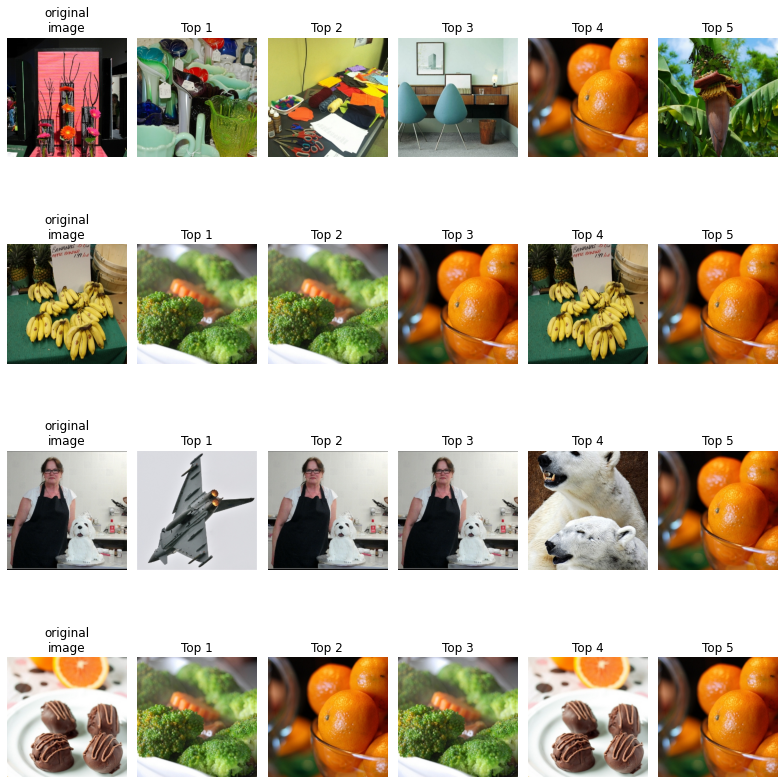

In [43]:
print("Forward retrieval")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval


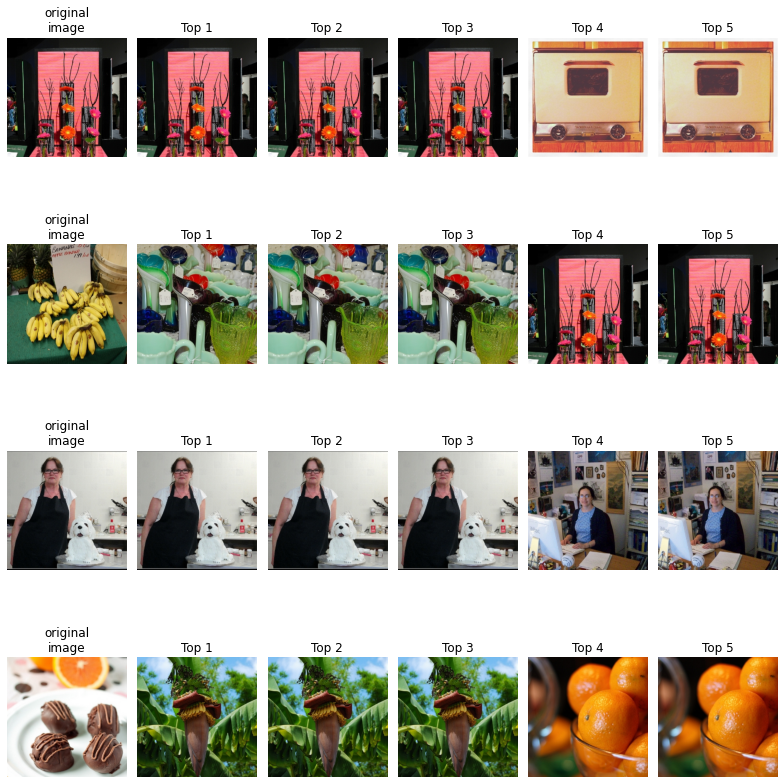

In [44]:
print("Backward retrieval")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# Reconstruction evaluation

### Load model checkpoint

In [3]:
model_name = "prior-w-voxel2clip"

outdir = f'../train_logs/models/{model_name}/test'

ckpt_path = os.path.join(outdir, f'ckpt-best.pth')
print("ckpt_path",ckpt_path)

checkpoint = torch.load(ckpt_path, map_location=device)

# utils.plot_brainnet_ckpt(ckpt_path)

ckpt_path ../train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth


### Load pretrained weights onto model

In [4]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth
diffusion_prior = BrainDiffusionPrior.from_pretrained(
    dict(),
    dict(
        condition_on_text_encodings=False,
        timesteps=1000,
        voxel2clip=voxel2clip,
    ),
)

diffusion_prior.load_state_dict(checkpoint['model_state_dict'])
diffusion_prior.eval().to(device)
print("loaded")

loaded


### Prep data loader

In [5]:
batch_size = 4

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_val_samples=4, # should be None!
        seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
train_url /scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar
val_url /scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 4
global_batch_size 4
num_worker_batches 6787
num_train 27150
num_val 4
cache_dir None
validation: num_worker_batches 1
idx 0
voxel.shape torch.Size([4, 15724])
img_input.shape torch.Size([4, 3, 256, 256])
key[:2] ['sample09960', 'sample01071']


### Load SD variations model

In [30]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

#sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
sd_cache_dir = '/scratch/gpfs/ps6938/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
    from diffusers import StableDiffusionImageVariationPipeline
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained("lambdalabs/sd-image-variations-diffusers", revision="v2.0")
    sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet").to(device)
vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae").to(device)
noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)

unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae.eval()
vae.requires_grad_(False)
print("loaded")

loaded


## Reconstruction via diffusion, one at a time
This will take awhile!!

2023-03-08 11:49:30
all_brain_recons.shape torch.Size([4, 4, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([4, 3, 256, 256])
2023-03-08 11:50:05


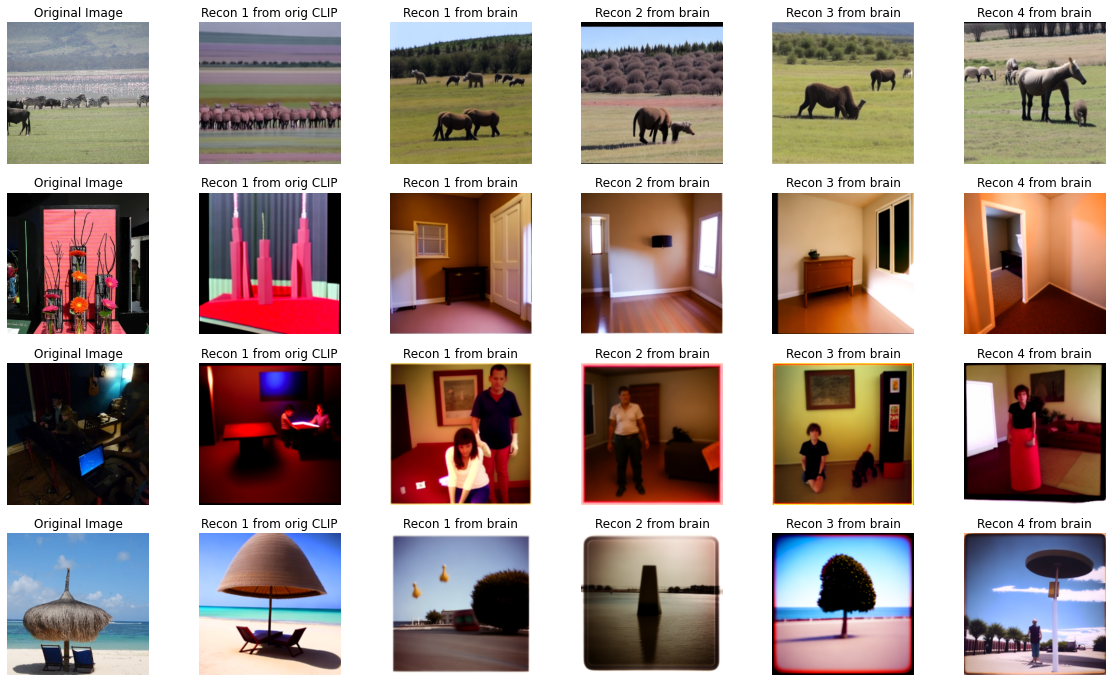

In [31]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
# for val_i, (voxel, img, trial) in enumerate(val_dl):
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
            img, voxel,
            diffusion_prior, 
            clip_extractor, unet, vae, noise_scheduler,
            img_lowlevel = None,
            num_inference_steps = 20,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .6,
            timesteps = 1000,
            seed = seed,
            distributed = distributed,
            plotting = True,
        )
        grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))

all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) #35 seconds

2023-03-08 11:48:02
all_brain_recons.shape torch.Size([4, 4, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([4, 3, 256, 256])
2023-03-08 11:49:02


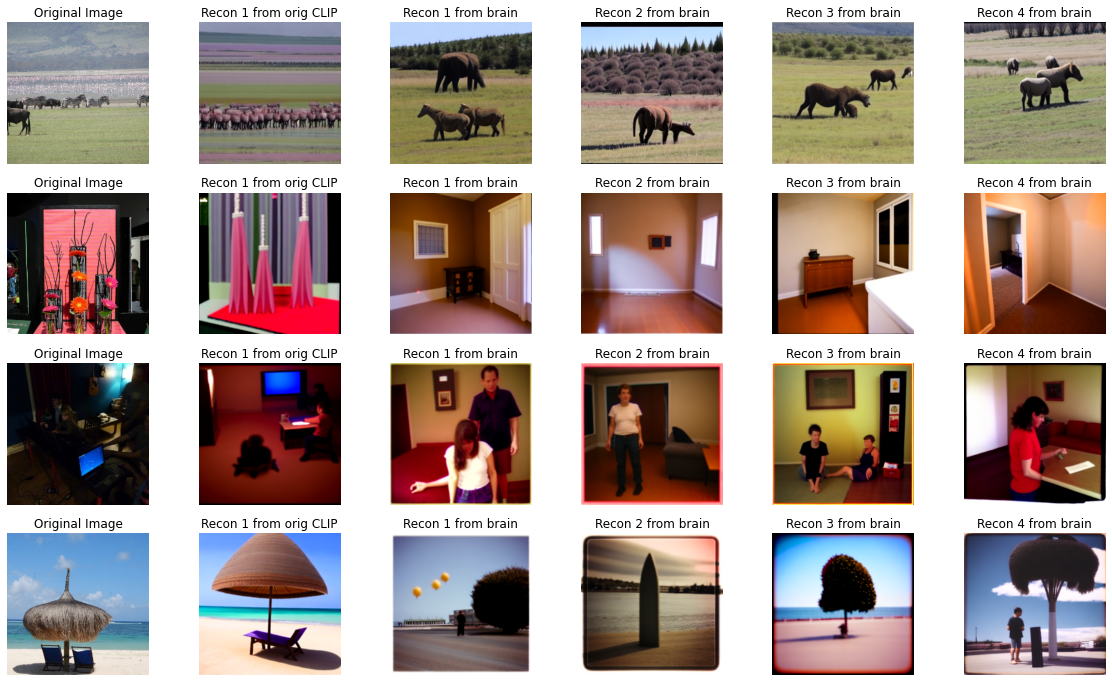

In [29]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
# for val_i, (voxel, img, trial) in enumerate(val_dl):
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
            img, voxel,
            diffusion_prior, 
            clip_extractor, unet, vae, noise_scheduler,
            img_lowlevel = None,
            num_inference_steps = 50,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .6,
            timesteps = 1000,
            seed = seed,
            distributed = distributed,
            plotting = True,
        )
        grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))
                
all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) # 70 seconds

2023-03-08 11:47:26
all_brain_recons.shape torch.Size([4, 4, 3, 512, 512])
all_clip_recons.shape torch.Size([4, 1, 3, 512, 512])
all_images.shape torch.Size([4, 3, 256, 256])
2023-03-08 11:48:02


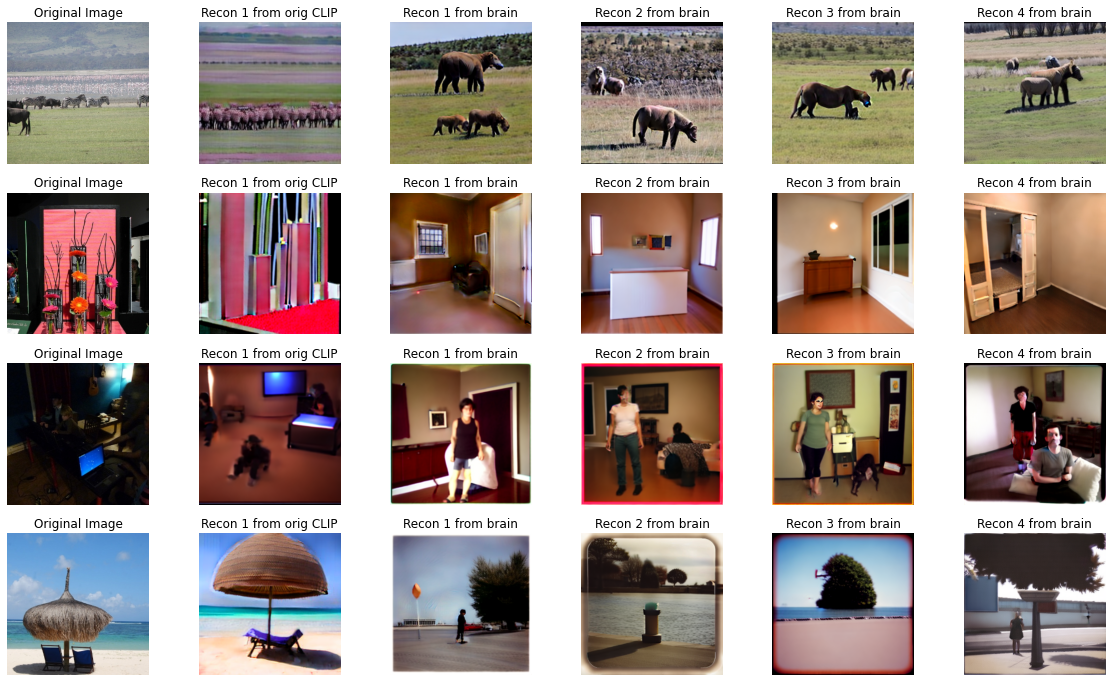

In [28]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
all_images = None
all_clip_recons = None
all_brain_recons = None
recons_per_clip = 1
recons_per_brain = 4
# for val_i, (voxel, img, trial) in enumerate(val_dl):
with torch.no_grad():
    with torch.cuda.amp.autocast():
        grid, clip_recons, brain_recons = utils.reconstruct_from_clip(
            img, voxel,
            diffusion_prior, 
            clip_extractor, unet, vae, noise_scheduler,
            img_lowlevel = None,
            num_inference_steps = 20,
            n_samples_save = batch_size,
            recons_per_clip = recons_per_clip,
            recons_per_brain = recons_per_brain,
            guidance_scale = 7.5,
            img2img_strength = .6,
            timesteps = 1000,
            seed = seed,
            distributed = distributed,
            plotting = True,
        )
        grid.savefig(os.path.join(outdir, f'val_recons_{val_i}_batchsize{batch_size}.png'))
        if all_brain_recons is None:
            all_brain_recons = brain_recons
            all_clip_recons = clip_recons
            all_images = img
        else:
            all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
            all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
            all_images = torch.vstack((all_images,img))
                
all_brain_recons = all_brain_recons.view(len(all_brain_recons)//recons_per_brain,-1,3,512,512)
all_clip_recons = all_clip_recons.view(len(all_clip_recons)//recons_per_clip,-1,3,512,512)

# torch.save(all_brain_recons,f'{outdir}/all_brain_recons')
# torch.save(all_clip_recons,f'{outdir}/all_clip_recons')
# torch.save(all_images,f'{outdir}/all_images')

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')) # 36 seconds

In [ ]:
# load variables if above cell was previously completed
all_brain_recons = torch.load(f'{outdir}/all_brain_recons')
all_clip_recons = torch.load(f'{outdir}/all_clip_recons')
all_images = torch.load(f'{outdir}/all_images')

## FID evaluation

In [12]:
import  pytorch_fid_wrapper as pfw

# using last feature layer (2048-dim) before FCs, as used in mind_reader
# can lower batch size if needed for memory
pfw.set_config(batch_size=all_images.shape[0], dims=2048, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(all_brain_recons[:,0].float(), real_images=all_images.float())
print(val_fid)

/home/ps6938/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ps6938/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


422.7670402000103


## 2-way identification

In [134]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():        
                real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
                fake = model(preprocess(recon[0]).unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = model(preprocess(all_brain_recons[rand_idx,0]).unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake)
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

def two_way_identification_clip(all_brain_recons, all_images, num_loops=10):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():       
                real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
                fake = clip_extractor.embed_image(recon[0].unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = clip_extractor.embed_image(all_brain_recons[rand_idx,0].unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake.item())
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

### AlexNet

In [3]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
preprocess = weights.transforms()

layer = 'late' # corresponds to layers used in Takagi & Nishimoto
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
model.avgpool=nn.Identity()
model.classifier=nn.Identity()
print(model)

# all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
        
# print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
# print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Identity()
  )
  (avgpool): Identity()
  (classifier): Identity()
)


### InceptionV3

In [135]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=30)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

100%|███████████████████████████████████████████| 30/30 [01:54<00:00,  3.82s/it]

2-way Percent Correct (mu, std): 0.65 | 0.15
Avg l2dist_fake (mu, std): 0.0150 | 0.0000


### CLIP

In [109]:
all_per_correct, all_l2dist_list = two_way_identification_clip(all_brain_recons, all_images, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.61it/s]

2-way Percent Correct (mu, std): 0.83 | 0.11
Avg l2dist_fake (mu, std): 0.0259 | 0.0000
